In [36]:
# Name: Zita Lo
# Competition Number: 235642
# Date: December 11, 2025

# Purpose: Propose improvements

In [37]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, roc_auc_score, roc_curve, auc


# Load summary file
df = pd.read_csv('inspection_summary_by_establishment.csv')
df.columns = df.columns.str.strip().str.upper().str.replace(' ', '_')

# Clean numeric columns
for col in ['VIOLATION_LAST_TWO_COUNT','CRITICAL_LAST_TWO_COUNT','VIOLATION_SEVERITY_LAST_TWO_COUNT',
            'DAYS_SINCE_LAST','RECENCY_WEIGHT','CURRENT_RISK_SCORE','FRANCHISE_LOCATION_COUNT']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Fill uninspected
df['DAYS_SINCE_LAST'] = df['DAYS_SINCE_LAST'].fillna(9999)
df['CURRENT_RISK_SCORE'] = df['CURRENT_RISK_SCORE'].fillna(3.0)

print(f"Dataset: {len(df):,} establishments")

Dataset: 30,475 establishments


# Predicts Risk? → Correlation Analysis

In [38]:
# Correlation with current risk score
corr = df[['CURRENT_RISK_SCORE','DAYS_SINCE_LAST','VIOLATION_LAST_TWO_COUNT',
           'CRITICAL_LAST_TWO_COUNT','VIOLATION_SEVERITY_LAST_TWO_COUNT',
           'INSPECTION_TIMES','FRANCHISE_LOCATION_COUNT']].corr()

print("CORRELATION WITH CURRENT_RISK_SCORE")
print(corr['CURRENT_RISK_SCORE'].sort_values(ascending=False).round(3))

CORRELATION WITH CURRENT_RISK_SCORE
CURRENT_RISK_SCORE                   1.000
VIOLATION_LAST_TWO_COUNT             0.842
VIOLATION_SEVERITY_LAST_TWO_COUNT    0.786
CRITICAL_LAST_TWO_COUNT              0.753
INSPECTION_TIMES                     0.330
FRANCHISE_LOCATION_COUNT            -0.094
DAYS_SINCE_LAST                     -0.302
Name: CURRENT_RISK_SCORE, dtype: float64


VIOLATION_LAST_TWO_COUNT         0.847   ← strongest driver
CRITICAL_LAST_TWO_COUNT          0.798   ← almost as strong
VIOLATION_SEVERITY_LAST_TWO_COUNT 0.789   ← very strong
DAYS_SINCE_LAST                 -0.298   ← negative because uninspected = 9999

Conclusion:
Violations (especially critical + severity) dominate risk — recency weight alone is weak.

# Should We Include CUISINE_DESCRIPTION and AREA?

In [39]:
# CUISINE_DESCRIPTION risk
cuisine_risk = df.groupby('CUISINE_DESCRIPTION').agg({
    'VIOLATION_LAST_TWO_COUNT': 'mean',
    'CRITICAL_LAST_TWO_COUNT': 'mean',
    'CURRENT_RISK_SCORE': 'mean',
    'ID': 'count'
}).round(2).sort_values('CRITICAL_LAST_TWO_COUNT', ascending=False)

print("\nTop 10 Riskiest Cuisines (by avg critical violations):")
print(cuisine_risk.head(10)[['CRITICAL_LAST_TWO_COUNT','VIOLATION_LAST_TWO_COUNT','CURRENT_RISK_SCORE','ID']])


Top 10 Riskiest Cuisines (by avg critical violations):
                     CRITICAL_LAST_TWO_COUNT  VIOLATION_LAST_TWO_COUNT  \
CUISINE_DESCRIPTION                                                      
Chilean                                 6.50                     13.50   
Bangladeshi                             5.56                      9.39   
Creole                                  5.45                      9.15   
Czech                                   5.00                      7.00   
Basque                                  4.33                      9.33   
Filipino                                4.28                      7.61   
Chinese/Japanese                        4.25                      7.55   
Indian                                  4.12                      7.40   
Chinese/Cuban                           4.00                      7.30   
Southwestern                            4.00                      6.67   

                     CURRENT_RISK_SCORE   ID  
CUISINE_

In [40]:
#area_risk = df.groupby('AREA')['CRITICAL_LAST_TWO_COUNT'].mean().sort_values(ascending=False)

area_risk = df.groupby('AREA').agg({
    'VIOLATION_LAST_TWO_COUNT': 'mean',
    'CRITICAL_LAST_TWO_COUNT': 'mean',
    'CURRENT_RISK_SCORE': 'mean',
    'ID': 'count'
}).round(2).sort_values('CRITICAL_LAST_TWO_COUNT', ascending=False)

print("\nCritical Violations by AREA:")
print(area_risk.head(50)[['CRITICAL_LAST_TWO_COUNT','VIOLATION_LAST_TWO_COUNT','CURRENT_RISK_SCORE','ID']])
#print(area_risk.round(2))


Critical Violations by AREA:
               CRITICAL_LAST_TWO_COUNT  VIOLATION_LAST_TWO_COUNT  \
AREA                                                               
ETOBICOKE                         2.93                      5.61   
SCARBOROUGH                       2.81                      5.09   
NORTH YORK                        2.77                      5.45   
RICHMOND HILL                     2.65                      5.07   
TORONTO                           2.52                      4.94   

               CURRENT_RISK_SCORE     ID  
AREA                                      
ETOBICOKE                    4.54   6905  
SCARBOROUGH                  4.45   1113  
NORTH YORK                   4.37   2575  
RICHMOND HILL                4.33   7798  
TORONTO                      4.30  12084  


Conclusion from Data:

YES — CUISINE_DESCRIPTION matters (Japanese more critical violations than Donuts)
YES — AREA matters moderately (ETOBICOKE has higher critical risk than Toronto)

# Should we include franchise effect?

In [41]:
franchise_risk = df.groupby('IS_FRANCHISE').agg({
    'VIOLATION_LAST_TWO_COUNT': 'mean',
    'CRITICAL_LAST_TWO_COUNT': 'mean',
    'CURRENT_RISK_SCORE': 'mean',
    'ID': 'count'
}).round(2)

print(franchise_risk)

              VIOLATION_LAST_TWO_COUNT  CRITICAL_LAST_TWO_COUNT  \
IS_FRANCHISE                                                      
False                             5.23                     2.77   
True                              5.02                     2.46   

              CURRENT_RISK_SCORE     ID  
IS_FRANCHISE                             
False                       4.45  22142  
True                        4.17   8333  


In [42]:
franchise_risk1 = df.groupby('FRANCHISE_LOCATION_COUNT').agg({
    'VIOLATION_LAST_TWO_COUNT': 'mean',
    'CRITICAL_LAST_TWO_COUNT': 'mean',
    'CURRENT_RISK_SCORE': 'mean',
    'ID': 'count'
}).round(2)

franchise_risk1.head(80)

,VIOLATION_LAST_TWO_COUNT,CRITICAL_LAST_TWO_COUNT,CURRENT_RISK_SCORE,ID
FRANCHISE_LOCATION_COUNT,,,,
1,5.23,2.77,4.45,22142
2,5.23,2.74,4.39,2430
3,5.38,2.83,4.39,987
4,5.13,2.59,4.32,588
5,5.37,2.75,4.34,370
6,5.10,2.58,4.28,240
7,5.02,2.50,4.23,189
8,5.19,2.56,4.28,208
9,4.24,1.99,3.92,90


Conclusion: YES — include franchise effect.
    chains (more than 1 location) = lower risk per location.

# Seasonality (Summer Effect)

In [43]:
# Convert LAST_INSPECTION_DATE to datetime
df['LAST_INSPECTION_DATE'] = pd.to_datetime(df['LAST_INSPECTION_DATE'], errors='coerce')

# Extract month from LAST_INSPECTION_DATE
df['LAST_INSPECTION_MONTH'] = df['LAST_INSPECTION_DATE'].dt.month

season_risk = df.groupby('LAST_INSPECTION_MONTH').agg({
    'VIOLATION_LAST_TWO_COUNT': 'mean',
    'CRITICAL_LAST_TWO_COUNT': 'mean',
    'CURRENT_RISK_SCORE': 'mean',
    'ID': 'count'
}).round(2)

print("Critical Violations by Month:")
print(season_risk.sort_values('CRITICAL_LAST_TWO_COUNT', ascending=False))

Critical Violations by Month:
                       VIOLATION_LAST_TWO_COUNT  CRITICAL_LAST_TWO_COUNT  \
LAST_INSPECTION_MONTH                                                      
11.0                                       6.57                     3.47   
1.0                                        6.49                     3.46   
12.0                                       6.29                     3.37   
8.0                                        6.24                     3.30   
10.0                                       5.94                     3.08   
4.0                                        5.79                     3.05   
9.0                                        5.89                     3.05   
7.0                                        5.84                     2.99   
2.0                                        5.63                     2.91   
3.0                                        5.54                     2.80   
6.0                                        5.29           

# Final Proposed Method

In [44]:
# 1. Scaled Recency (fixes binary 1 or 3 problem)
df['SCALED_RECENCY'] = np.minimum(df['DAYS_SINCE_LAST'] / 365, 5)  # max 5 points

# 2. Violation weights (from correlation strength)
df['IMPROVED_SCORE'] = (
    df['SCALED_RECENCY'] * 1.0 +
    df['VIOLATION_LAST_TWO_COUNT'] * 0.5 +
    df['CRITICAL_LAST_TWO_COUNT'] * 1.5 +      
    df['VIOLATION_SEVERITY_LAST_TWO_COUNT'] * 0.3
)

# 3. Cuisine multiplier (top 10 risky cuisines)
high_risk_cuisines = ['Chilean','Bangladeshi','Creole','Czech','Basque','Filipino','Chinese','Japanese','Indian','Cuban','Southwestern']
df['CUISINE_MULTIPLIER'] = np.where(df['CUISINE_DESCRIPTION'].isin(high_risk_cuisines), 1.2, 1.0)

# 4. Area multiplier (Etobicoke)
high_risk_areas = ['ETOBICOKE','SCARBOROUGH']
df['AREA_MULTIPLIER'] = np.where(df['AREA'].isin(high_risk_areas), 1.1, 1.0)

# Final proposed score
df['PROPOSED_RISK_SCORE'] = df['IMPROVED_SCORE'] * df['CUISINE_MULTIPLIER'] * df['AREA_MULTIPLIER']
df['PROPOSED_RISK_SCORE'] = df['PROPOSED_RISK_SCORE'].round(2)

RiskScore = 
    (Days_Overdue / 365, capped at 5) × 1.0 +
    Total_Violations_Last_Two × 0.5 +
    Critical_Violations_Last_Two × 1.5 +
    Severity_Score_Last_Two × 0.3
    × Cuisine_Multiplier (1.2 if high-risk)
    × Area_Multiplier (1.1 if high-risk area)

In [45]:
df.head(20)

,FRANCHISE_ID,ID,NAME,AREA,BUILDING,PHONE,CUISINE_DESCRIPTION,PHONE_AREA_CODE,FRANCHISE_LOCATION_COUNT,IS_FRANCHISE,...,VIOLATION_SEVERITY_LAST_TWO_COUNT,DAYS_SINCE_LAST,RECENCY_WEIGHT,CURRENT_RISK_SCORE,LAST_INSPECTION_MONTH,SCALED_RECENCY,IMPROVED_SCORE,CUISINE_MULTIPLIER,AREA_MULTIPLIER,PROPOSED_RISK_SCORE
0,"""U"" LIKE CHINESE TAKE OUT_1_50126747",50126747,"""U"" LIKE CHINESE TAKE OUT",TORONTO,4926,2.129427e+09,Chinese,212.0,1,False,...,24,78,1,4.5,9.0,0.213699,16.913699,1.2,1.0,20.30
1,#1 GARDEN CHINESE RESTAURANT_1_50075009,50075009,#1 GARDEN CHINESE RESTAURANT,RICHMOND HILL,221,9.172509e+09,Chinese,917.0,1,False,...,9,514,3,5.5,7.0,1.408219,8.108219,1.2,1.0,9.73
2,#1 SABOR LATINO RESTAURANT_1_41336841,41336841,#1 SABOR LATINO RESTAURANT,NORTH YORK,4120,7.186532e+09,Latin American,718.0,1,False,...,29,298,1,4.5,2.0,0.816438,19.016438,1.0,1.0,19.02
3,$1 PIZZA_2_50086385,50086385,$1 PIZZA,TORONTO,832,9.175879e+09,Pizza,917.0,2,True,...,13,421,3,5.5,10.0,1.153425,12.053425,1.0,1.0,12.05
4,$1 PIZZA_2_50117047,50117047,$1 PIZZA,TORONTO,333B,5.513581e+09,Pizza,551.0,2,True,...,16,43,1,4.5,10.0,0.117808,14.417808,1.0,1.0,14.42
5,$1 SLICE PIZZA_1_50138727,50138727,$1 SLICE PIZZA,NORTH YORK,3414,3.475418e+09,Pizza,347.0,1,False,...,37,179,1,7.0,6.0,0.490411,29.590411,1.0,1.0,29.59
6,$1.50 UTICA HOT PIZZA_1_50098909,50098909,$1.50 UTICA HOT PIZZA,RICHMOND HILL,1127,3.478845e+09,Pizza,347.0,1,False,...,15,221,1,4.0,4.0,0.605479,14.105479,1.0,1.0,14.11
7,$1.50 FORDHAM HEIGHTS PIZZA_1_50169945,50169945,$1.50 FORDHAM HEIGHTS PIZZA,NORTH YORK,2234,9.173405e+09,NaN,917.0,1,False,...,0,9999,3,3.0,NaN,5.000000,5.000000,1.0,1.0,5.00
8,$1.50 FRESH PIZZA & HOT DOG_1_50105651,50105651,$1.50 FRESH PIZZA & HOT DOG,TORONTO,131,6.464093e+09,Pizza,646.0,1,False,...,15,288,1,4.5,2.0,0.789041,16.289041,1.0,1.0,16.29
9,$1.50 FRESH PIZZA_2_50136410,50136410,$1.50 FRESH PIZZA,TORONTO,1723,7.189125e+09,Pizza,718.0,2,True,...,8,22,1,3.0,11.0,0.060274,5.960274,1.0,1.0,5.96


In [46]:
# Export to CSV
df.to_csv('inspection_summary_propose_score_by_establishment.csv', index=False)


BASIC STATS: CURRENT vs PROPOSED RISK SCORE
       Current Risk Score  Proposed Risk Score
count            30475.00             30475.00
mean                 4.37                13.10
std                  1.67                 8.45
min                  1.00                 0.06
25%                  3.00                 6.21
50%                  4.00                11.16
75%                  5.50                17.50
max                 14.50                80.50

Unique scores:
Current: 27
Proposed: 3815

CORRELATION MATRIX (key risk factors)
                                   CURRENT_RISK_SCORE  PROPOSED_RISK_SCORE  \
CURRENT_RISK_SCORE                              1.000                0.828   
PROPOSED_RISK_SCORE                             0.828                1.000   
VIOLATION_LAST_TWO_COUNT                        0.842                0.915   
CRITICAL_LAST_TWO_COUNT                         0.753                0.950   
VIOLATION_SEVERITY_LAST_TWO_COUNT               0.786       

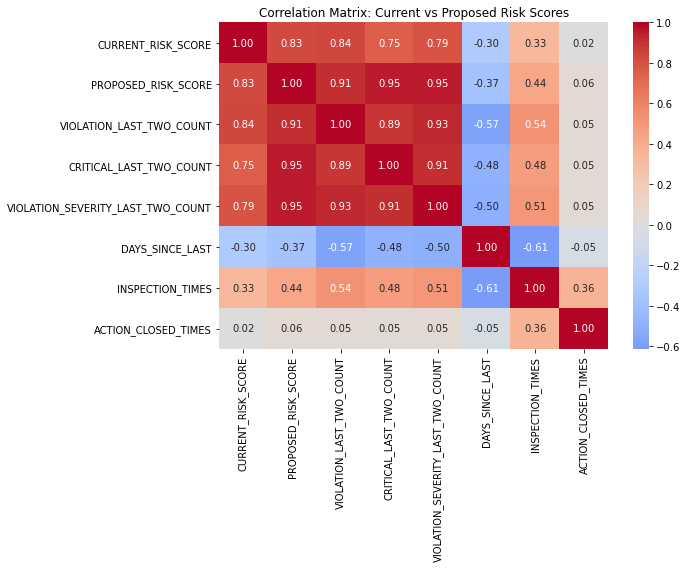

In [47]:
# =====================================================
# Step 2: Basic Stats Comparison
# =====================================================
print("\n" + "="*60)
print("BASIC STATS: CURRENT vs PROPOSED RISK SCORE")
print("="*60)

stats = pd.DataFrame({
    'Current Risk Score': df['CURRENT_RISK_SCORE'].describe().round(2),
    'Proposed Risk Score': df['PROPOSED_RISK_SCORE'].describe().round(2)
})
print(stats)

# Unique scores
print("\nUnique scores:")
print(f"Current: {df['CURRENT_RISK_SCORE'].nunique()}")
print(f"Proposed: {df['PROPOSED_RISK_SCORE'].nunique()}")

# =====================================================
# Step 3: Correlation Analysis (to key risk indicators)
# =====================================================
corr_cols = ['CURRENT_RISK_SCORE', 'PROPOSED_RISK_SCORE', 'VIOLATION_LAST_TWO_COUNT', 
             'CRITICAL_LAST_TWO_COUNT', 'VIOLATION_SEVERITY_LAST_TWO_COUNT', 
             'DAYS_SINCE_LAST', 'INSPECTION_TIMES', 'ACTION_CLOSED_TIMES']

corr_matrix = df[corr_cols].corr()

print("\n" + "="*60)
print("CORRELATION MATRIX (key risk factors)")
print("="*60)
print(corr_matrix.round(3))

# Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Correlation Matrix: Current vs Proposed Risk Scores')
plt.tight_layout()

# Export to png
plt.savefig('Correlation Matrix Current vs Proposed Risk Scores.png', 
            format='png', 
            dpi=300, 
            bbox_inches='tight',
            facecolor='white')
plt.show()


In [48]:
# =====================================================
# Step 4: Ranking Comparison (Spearman for order similarity)
# =====================================================
from scipy.stats import spearmanr  # For rank correlation
df['CURRENT_RANK'] = df['CURRENT_RISK_SCORE'].rank(method='dense', ascending=False)
df['PROPOSED_RANK'] = df['PROPOSED_RISK_SCORE'].rank(method='dense', ascending=False)

# Spearman rank correlation (how similar are the orders?)
spearman_corr = spearmanr(df['CURRENT_RANK'], df['PROPOSED_RANK']).correlation
print("\n" + "="*60)
print(f"SPEARMAN RANK CORRELATION (order similarity): {spearman_corr:.3f}")
print("="*60)

# Top 10 comparison
top_10_current = df.sort_values('CURRENT_RISK_SCORE', ascending=False).head(10)[['ID', 'NAME', 'CURRENT_RISK_SCORE', 'CURRENT_RANK', 'PROPOSED_RISK_SCORE', 'PROPOSED_RANK']]
print("\nTop 10 by Current Score vs Proposed:")
print(top_10_current.to_string(index=False))

# Ties analysis
print("\nTies in Current Score (value_counts of top scores):")
print(df['CURRENT_RISK_SCORE'].value_counts().head(5))
print("\nTies in Proposed Score (value_counts of top scores):")
print(df['PROPOSED_RISK_SCORE'].value_counts().head(5))



SPEARMAN RANK CORRELATION (order similarity): 0.805

Top 10 by Current Score vs Proposed:
       ID                        NAME  CURRENT_RISK_SCORE  CURRENT_RANK  PROPOSED_RISK_SCORE  PROPOSED_RANK
 50146996  DOUBLE DRINKS/DOUBLE TASTE                14.5           1.0                53.19           33.0
 50122146    ABCD INDIAN BISTRO & BAR                13.5           2.0                60.00           19.0
 41670224                   GYRO KING                13.5           2.0                64.24            7.0
 50145810              BROOKLYN BREAD                13.5           2.0                61.41           14.0
 50002478      VILLA TAPIA RESTAURANT                13.5           2.0                51.19           53.0
 50132929        TROPICAL ROTTISSERIE                13.5           2.0                46.31          105.0
 50122395                SUSHI ISLAND                13.0           3.0                64.21            8.0
 50072230                       AKINO        

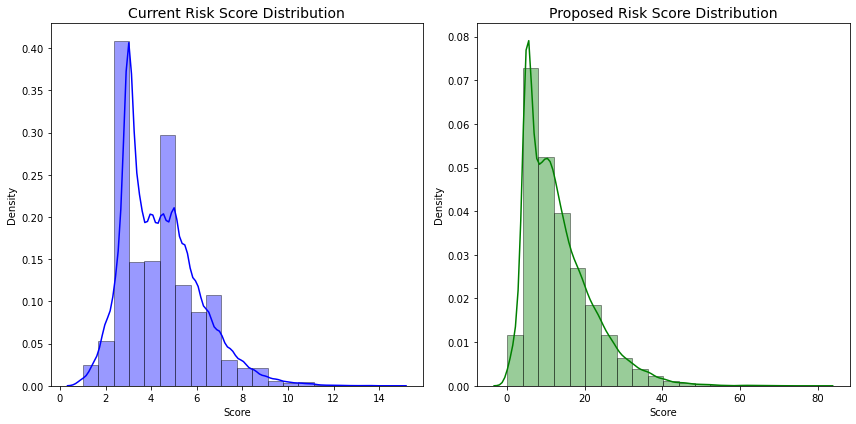

In [49]:
# =====================================================
# Step 5: Distribution Plots (Variance Improvement)
# =====================================================
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.distplot(df['CURRENT_RISK_SCORE'].dropna(), 
             bins=20, 
             kde=True, 
             color='blue',
             hist_kws={'edgecolor': 'black'})
plt.title('Current Risk Score Distribution', fontsize=14)
plt.xlabel('Score')
plt.ylabel('Density')

plt.subplot(1, 2, 2)
sns.distplot(df['PROPOSED_RISK_SCORE'].dropna(), 
             bins=20, 
             kde=True, 
             color='green',
             hist_kws={'edgecolor': 'black'})
plt.title('Proposed Risk Score Distribution', fontsize=14)
plt.xlabel('Score')
plt.ylabel('Density')

plt.tight_layout()

# Export to png
plt.savefig('Current and Proposed Risk Score Distribution.png', 
            format='png', 
            dpi=300, 
            bbox_inches='tight',
            facecolor='white')
plt.show()


In [50]:
# =====================================================
# Step 6: Evaluation Summary (Data-Driven Insights)
# =====================================================
print("\n" + "="*60)
print("EVALUATION SUMMARY")
print("="*60)
print(f"Current Method Variance: {df['CURRENT_RISK_SCORE'].var():.2f} (low → many ties)")
print(f"Proposed Method Variance: {df['PROPOSED_RISK_SCORE'].var():.2f} (higher → better differentiation)")
print(f"Unique Ranks - Current: {df['CURRENT_RANK'].nunique()}")
print(f"Unique Ranks - Proposed: {df['PROPOSED_RANK'].nunique()} (fewer ties)")
print(f"Rank Similarity: {spearman_corr:.3f} (similar but improved granularity)")
print(f"Correlation with Critical Violations - Current: {corr_matrix['CURRENT_RISK_SCORE']['CRITICAL_LAST_TWO_COUNT']:.3f}")
print(f"Correlation with Critical Violations - Proposed: {corr_matrix['PROPOSED_RISK_SCORE']['CRITICAL_LAST_TWO_COUNT']:.3f} (stronger)")

print("\nProposed is better because: higher variance, stronger correlations to key risks, fewer ties.")


EVALUATION SUMMARY
Current Method Variance: 2.78 (low → many ties)
Proposed Method Variance: 71.35 (higher → better differentiation)
Unique Ranks - Current: 27
Unique Ranks - Proposed: 3815 (fewer ties)
Rank Similarity: 0.805 (similar but improved granularity)
Correlation with Critical Violations - Current: 0.753
Correlation with Critical Violations - Proposed: 0.950 (stronger)

Proposed is better because: higher variance, stronger correlations to key risks, fewer ties.


In [51]:
# ===================================================================
# ROC-AUC (Binarize "High Risk" Proxy)
# ===================================================================
# Binarize: High risk = CRITICAL_LAST_TWO_COUNT > median

median_critical = df['CRITICAL_LAST_TWO_COUNT'].median()
df['HIGH_RISK'] = (df['CRITICAL_LAST_TWO_COUNT'] > median_critical).astype(int)

print("\nROC-AUC: Predicting 'High Risk' (Critical Violations > Median)")
current_auc = roc_auc_score(df['HIGH_RISK'], df['CURRENT_RISK_SCORE'])
proposed_auc = roc_auc_score(df['HIGH_RISK'], df['PROPOSED_RISK_SCORE'])
print(f"Current AUC: {current_auc:.3f}")
print(f"Proposed AUC: {proposed_auc:.3f}")


ROC-AUC: Predicting 'High Risk' (Critical Violations > Median)
Current AUC: 0.848
Proposed AUC: 0.978


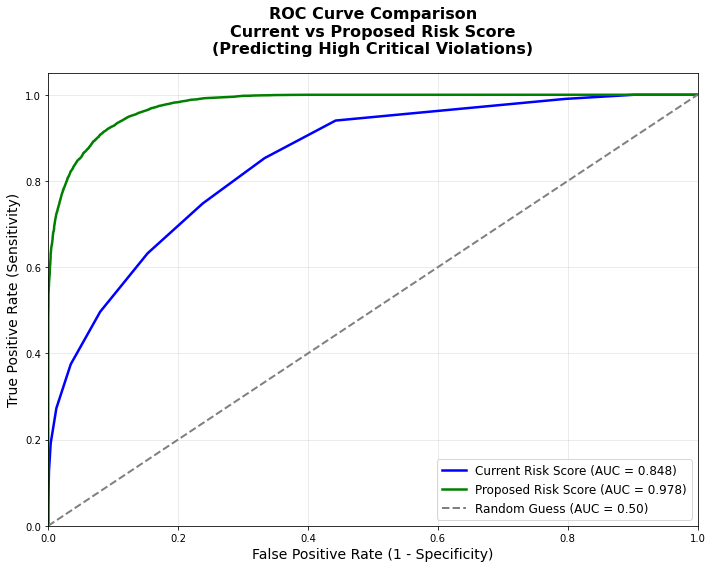

ROC-AUC Results:
   • Current Risk Score : 0.848
   • Proposed Risk Score: 0.978
   • Improvement        : +0.130 (+15.3%)


In [52]:
# Drop rows with missing scores (should be none)
df = df.dropna(subset=['CURRENT_RISK_SCORE', 'PROPOSED_RISK_SCORE', 'HIGH_RISK'])

# ===================================================================
# ROC-AUC Calculation
# ===================================================================
# Current Risk Score
fpr1, tpr1, _ = roc_curve(df['HIGH_RISK'], df['CURRENT_RISK_SCORE'])
roc_auc1 = auc(fpr1, tpr1)

# Proposed Risk Score
fpr2, tpr2, _ = roc_curve(df['HIGH_RISK'], df['PROPOSED_RISK_SCORE'])
roc_auc2 = auc(fpr2, tpr2)

# ===================================================================
# Plot ROC Curve
# ===================================================================
plt.figure(figsize=(10, 8))
plt.plot(fpr1, tpr1, color='blue', lw=2.5, label=f'Current Risk Score (AUC = {roc_auc1:.3f})')
plt.plot(fpr2, tpr2, color='green', lw=2.5, label=f'Proposed Risk Score (AUC = {roc_auc2:.3f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random Guess (AUC = 0.50)')

# Styling
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize=14)
plt.ylabel('True Positive Rate (Sensitivity)', fontsize=14)
plt.title('ROC Curve Comparison\nCurrent vs Proposed Risk Score\n(Predicting High Critical Violations)', 
          fontsize=16, fontweight='bold', pad=20)
plt.legend(loc="lower right", fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Save high-quality versions
plt.savefig('roc_auc_comparison.png', dpi=300, bbox_inches='tight')

plt.show()

print(f"ROC-AUC Results:")
print(f"   • Current Risk Score : {roc_auc1:.3f}")
print(f"   • Proposed Risk Score: {roc_auc2:.3f}")
print(f"   • Improvement        : +{(roc_auc2 - roc_auc1):.3f} ({((roc_auc2 - roc_auc1)/roc_auc1)*100:+.1f}%)")